For this homework, make sure that you format your notbook nicely and cite all sources in the appropriate sections. Programmatically generate or embed any figures or graphs that you need.

Names: Calvin Zikakis, Sarah Schwallier

Section 1: Word2Vec paper questions
---------------------------

    1) Describe how a CBOW word embedding is generated.

    2) What is a CBOW word embedding and how is it different than a skip-gram word embedding?

    3) What is the task that the authors use to evaluate the generated word embeddings?

    4) What are PCA and t-SNE? Why are these important to the task of training and interpreting word embeddings?

Sources Cited
--------------------------
Efficient Estimation of Word Representations in Vector Space by Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean: https://arxiv.org/pdf/1301.3781.pdf  
J. Schler, M. Koppel, S. Argamon and J. Pennebaker (2006). Effects of Age and Gender on Blogging in Proceedings of 2006 AAAI Spring Symposium on Computational Approaches for Analyzing Weblogs.
SENTENCE ORDERING USING RECURRENT NEURAL NETWORKS by Lajanugen Logeswaran, Honglak Lee & Dragomir Radev
Speech and Language Processing
An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition by Daniel Jurafsky and James H. Martin

Section 2: Training your own word embeddings
--------------------------------

The spooky authors dataset consists of excerpts from authors of horror novels including Edgar Allan Poe, Mary Shelley, and HP Lovecraft. These excerpts each have a unique ID as well as a three letter tag describing which author wrote the excerpt. The data is split into a training set and a test set. The test set is lacking the three letter code which labels the author. 


We are using the The Blog Authorship Corpus for our secondary dataset. We decided on this dataset as it is comprised of 681,288 posts from 19,320 bloggers. We scanned through this database and pulled a small chunk of the total amount of posts. This was to reduce the overall size of the dataset to help with performance in training word embedding. This dataset will provide a data that is written with a style simular to normal human conversation simularly to the spooky authors dataset. This should help insure our generated sentences have a natural sound to them.





In [1]:
# import your libraries here
import numpy as np
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from collections import Counter

import keras
from keras import backend as K
import tensorflow as tf

### Comment out this section if you running on a laptop
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.75
session = tf.Session(config=config)
K.set_session(session)
### ---------------------------------------------------

from keras.layers import Dense, Activation, Flatten
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.utils import to_categorical


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import itertools
import seaborn as sns
import csv


%matplotlib inline

Using TensorFlow backend.


In [2]:
# -----------------Secondary Dataset Formatting and Trimming-------------------
# This cell trims and fixes the secondary dataset to get the data in a workable style
import re
from csv import reader


def format_secondaryDataset(training_file_path, output_file, sentence_length):
    '''
    this function takes the dataset and splits it to sentences and stores those in a txt file

    training_file_path = filepath of blogposts.csv
    output_file = outputfile name (.txt)
    sentence_length = minimum length sentences to grab (value is how many words per sentences)
    '''

    
    with open(training_file_path, "r", encoding="utf-8") as file:
        sentences = file.readlines()
    #open file
    
    file.close()
    
    output = open(output_file, "w+")
    
    count = 0
    
    for line in reader(sentences):
        blog_post = line[6]
        #Line[6] contains the blog post
        
        if count >= 7:
        #skip the stuff in the beggining. It's unneeded
        
            sentences = blog_post.split(".")
            #split the post on the periods to extract individual sentences
            
            for sentence in sentences:
            #loop over our list of sentences
            
                if sentence != "":
                #some blog posts contain '...'. This creates empty sentences. We don't want empty sentences
                    
                    #lets clean the sentence of symbols and make it all lowercase
                    
                    res = re.sub(' +', ' ', sentence)
                    res.strip('\t')
                    res.strip('\n')
                    #strip tabs and newlines
                    
                    lower = res.lower()
                    #make all lower case

                    whitelist = set('abcdefghijklmnopqrstuvwxyz 1234567890')
                    no_numbers_punct = ''.join(filter(whitelist.__contains__, lower))
                    #gets rid of punctuation

                    cleaned = no_numbers_punct.split()
                    
                    black_list = ['urllink']
                    #allows us to remove all 'urlLink' occurances
                    
                    if len(cleaned) >= sentence_length:
                        #adjust 4 if you only want longer sentences
                        #we are only concerned with sentences longer than 4 words
                        output.write(" ".join([i for i in cleaned if i not in black_list]) + "\n")
                    
                    
        if count == 2000:
        #Do not need this full dataset... It's 800mb's
            break
        
        count += 1
        

format_secondaryDataset("blogtext.csv", "secondaryDataset.txt", 5)

In [3]:
# code to train your word embeddings
from csv import reader
from gensim.models import Word2Vec

EMB = 300


def convert_data(data):
#flattens data to 1D matrix
    data_flattened = []
    
    for sentences in data:
        for word in sentences:
            data_flattened.append(word)
    
    return data_flattened



def standardize_length(words,length):
    counter = 0
    output = []
    
    sentence = []
    for word in words:
        if counter < length:
            sentence.append(word)
        else:
            output.append(sentence)
            sentence = []
            counter = -1
        counter += 1
            
    return output

def convert_to_UNK(words):
    output = []
    counts = Counter(words)
    for word in words:
        if counts[word] <= 1:
            output.append('UNK')
        else:
            output.append(word)
    return output
            
    

# -----------------Primary Dataset-------------------

def Clean_data_primary_dataset(training_file_path):
    #This function tokenizes the primary dataset and returns a cleaned version where each word making up a sentence is a nested list inside a larger list of the corpus
    output_list = []

    with open(training_file_path, "r", encoding="utf-8") as file:
        sentences = file.readlines()
    #open file
    file.close()
    
    count = 0
        
    for line in reader(sentences):
        
        if count != 0:
        #don't want first sentence

            sentence = line[1]
            
            lower = sentence.lower()
            #make all lower case

            whitelist = set('abcdefghijklmnopqrstuvwxyz 1234567890')
            no_numbers_punct = ''.join(filter(whitelist.__contains__, lower))
            #gets rid of punctuation

            cleaned = no_numbers_punct.split()
            
            output_list.append(cleaned)
            
        count += 1

    return output_list


pri_Dataset = convert_data(Clean_data_primary_dataset("train.csv"))
#imports and cleans dataset

output_pri = convert_to_UNK(pri_Dataset)

sentences_primaryDataset = standardize_length(output_pri, 4)

model_primaryDataset = Word2Vec(sentences_primaryDataset, min_count=1, size=EMB, window=4, negative=10, iter=10, workers=4)
#creates word2vec model

#print(model_primaryDataset)
#model summary

words_primaryDataset = list(model_primaryDataset.wv.vocab)
print(len(words_primaryDataset), "<--- Primary Vocab Length")
#shows the vocab

#print(model_primaryDataset['sentence'])
#our model

# -----------------Secondary Dataset-------------------

#secondary dataset is stored as 'secondaryDataset.txt' after processing it

def tokenize_secondary_dataset(training_file_path):
    #tokenizes the secondary dataset and returns a cleaned version where each word making up a sentence is a nested list inside a larger list of the corpus
    
    output_list = []

    with open(training_file_path) as file:
        sentences = file.readlines()
        
    #open file
    file.close()
    
    for sentence in sentences:
    #loop over sentences
    
        words = sentence.split()
        #split sentences on the words
        
        output_list.append(words)
        #append words list to final output
    
    return output_list


sec_Dataset = convert_data(tokenize_secondary_dataset("secondaryDataset.txt"))
#secondary sentences

output_sec = convert_to_UNK(sec_Dataset)

sentences_secondaryDataset = standardize_length(output_sec, 4)

model_secondaryDataset = Word2Vec(sentences_secondaryDataset, min_count=1, size=EMB, window=4, negative=10, iter=10, workers=4)
#creates word2vec model

#print(model_secondaryDataset)
#model summary

words_secondaryDataset = list(model_secondaryDataset.wv.vocab)
#print(words_secondaryDataset)
#shows the vocab

#print(model_secondaryDataset['sentence'])
#our model


15756 <--- Primary Vocab Length


Sources Cited
--------------------------
An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition by Daniel Jurafsky and James H. Martin


Brownlee, Jason. “How to Develop Word Embeddings in Python with Gensim.” Machine Learning Mastery, 7 Aug. 2019, machinelearningmastery.com/develop-word-embeddings-python-gensim/.

Section 3: Evaluate the differences between the word embeddings
----------------------------

(make sure to include graphs, figures, and paragraphs with full sentences)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


Word:  imagined 

[('believed', 0.9694145917892456), ('described', 0.9692637920379639), ('supposed', 0.9675508737564087), ('agreed', 0.9673206806182861), ('understood', 0.965877890586853), ('suffered', 0.9609777331352234), ('failed', 0.959341287612915), ('remembered', 0.9581078290939331), ('spoken', 0.9568725824356079), ('experienced', 0.9534070491790771)] 

[('bigger', 0.9877041578292847), ('soda', 0.9854671359062195), ('jon', 0.9850544929504395), ('louder', 0.9849676489830017), ('blacks', 0.9847743511199951), ('frame', 0.984538733959198), ('damage', 0.9845044016838074), ('asians', 0.9844471216201782), ('unquote', 0.9842577576637268), ('ska', 0.984200119972229)] 

imagined
imagined


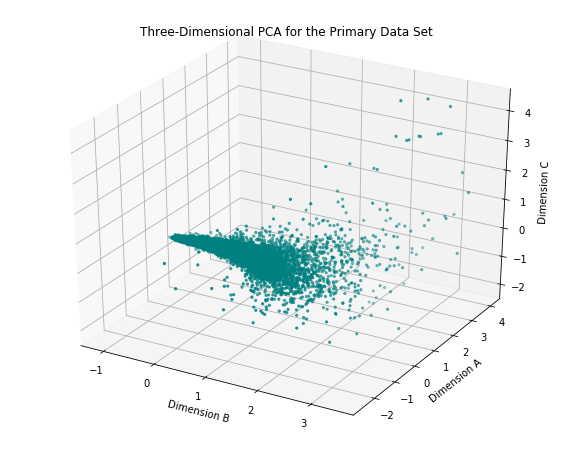

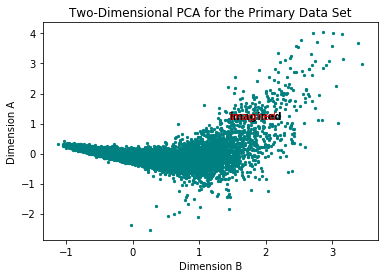

Word:  plucking 

[('avg', 0.9974811673164368), ('sdl', 0.9965892434120178), ('distracting', 0.9965375661849976), ('les', 0.996303141117096), ('columbo', 0.9962931275367737), ('coughs', 0.9962617754936218), ('foe', 0.9962472319602966), ('prima', 0.9961836934089661), ('begging', 0.9961221218109131), ('reubs', 0.9960999488830566)] 

[('avg', 0.9974811673164368), ('sdl', 0.9965892434120178), ('distracting', 0.9965375661849976), ('les', 0.996303141117096), ('columbo', 0.9962931275367737), ('coughs', 0.9962617754936218), ('foe', 0.9962472319602966), ('prima', 0.9961836934089661), ('begging', 0.9961221218109131), ('reubs', 0.9960999488830566)] 

plucking
plucking


/opt/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


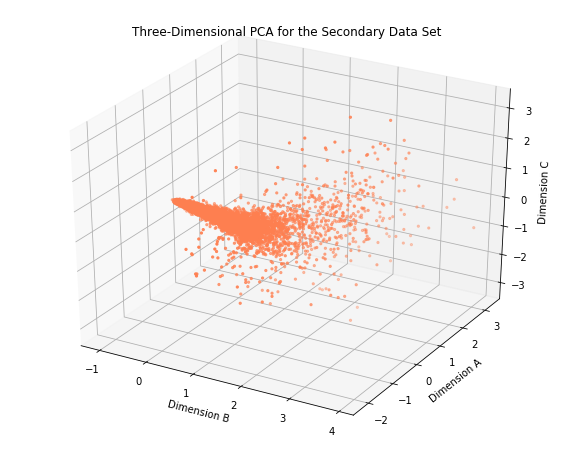

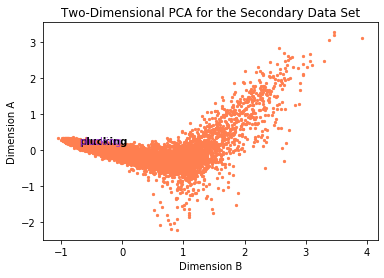

In [4]:
# -----------------Section 3: Evaluate the differences between the word embeddings-------------------
#This section is evaluating via PCAs
primaryModel = model_primaryDataset[model_primaryDataset.wv.vocab]
secondaryModel = model_secondaryDataset[model_secondaryDataset.wv.vocab]
#Retirives the vectors from each embedding

def buildSimilarWords(randWord, pSimilarWords, sSimilarWords):
    psList = []
    psList.append(randWord)
    for wordTuple in pSimilarWords:
        word  = wordTuple[0]
        if word not in words_secondaryDataset:
            psList.append(word)
    return psList

def getPrimaryIndex(word):
    for i, iWord in enumerate(list(model_primaryDataset.wv.vocab)):
        if word == iWord:
            return i

randIndex = np.random.randint(0, high=len(words_primaryDataset))
randWord = words_primaryDataset[randIndex]
while randWord not in words_secondaryDataset:
    randIndex = np.random.randint(0, high=len(words_primaryDataset))
    randWord = words_primaryDataset[randIndex]
pSimilarWords = model_primaryDataset.wv.most_similar(randWord)
sSimilarWords = model_secondaryDataset.wv.most_similar(randWord)
print("Word: ", randWord, "\n")
print(pSimilarWords, "\n")
print(sSimilarWords, "\n")
similarWords = buildSimilarWords(randWord, pSimilarWords, sSimilarWords)
dnpWord = model_primaryDataset.wv.doesnt_match(similarWords)
dnsWord = model_secondaryDataset.wv.doesnt_match(similarWords)
print(dnpWord)
print(dnsWord)

pcaP = PCA(n_components=3)
resultP = pcaP.fit_transform(primaryModel)
ax = plt.figure(figsize=(10,8)).gca(projection='3d')
ax.scatter(resultP[:, 0], resultP[:, 1], resultP[:, 2], s=5, color='teal')
words_primaryDataset = list(model_primaryDataset.wv.vocab)
ax.set_title('Three-Dimensional PCA for the Primary Data Set')
ax.set_xlabel('Dimension B')
ax.set_ylabel('Dimension A')
ax.set_zlabel('Dimension C')
#ax.text(resultP[randIndex, 0], resultP[randIndex, 1], resultP[randIndex, 2], randWord,  fontweight='bold')
#for word in similarWords:
#    if word != dnpWord and word != randWord:
#        p2 = getPrimaryIndex(word)
#        ax.text(resultP[p2, 0], resultP[p2, 1], resultP[p2, 2], word)
#p2 = words_primaryDataset.index(dnpWord)
#ax.text(resultP[p2, 0], resultP[p2, 1], resultP[p2, 2], dnpWord, color='red')
plt.show()
#PCA model for the primary dataset
pcaP = PCA(n_components=2)
resultP = pcaP.fit_transform(primaryModel)
plt.scatter(resultP[:, 0], resultP[:, 1], s=5, color='teal')
words_primaryDataset = list(model_primaryDataset.wv.vocab)
plt.title('Two-Dimensional PCA for the Primary Data Set')
plt.xlabel('Dimension B')
plt.ylabel('Dimension A')
plt.annotate(randWord, xy=(resultP[randIndex, 0], resultP[randIndex, 1]),  fontweight='bold')
for word in similarWords:
    if word != dnpWord and word != randWord:
        p2 = getPrimaryIndex(word)
        plt.annotate(word, xy=(resultP[p2, 0], resultP[p2, 1]))
p2 = words_primaryDataset.index(dnpWord)
plt.annotate(dnpWord, xy=(resultP[p2, 0], resultP[p2, 1]), color='red')
plt.show()
#PCA model for the primary dataset

randIndex = np.random.randint(0, high=len(words_secondaryDataset))
randWord = words_secondaryDataset[randIndex]
while randWord not in words_secondaryDataset:
    randIndex = np.random.randint(0, high=len(words_secondaryDataset))
    randWord = words_secondaryDataset[randIndex]
pSimilarWords = model_secondaryDataset.wv.most_similar(randWord)
sSimilarWords = model_secondaryDataset.wv.most_similar(randWord)
print("Word: ", randWord, "\n")
print(pSimilarWords, "\n")
print(sSimilarWords, "\n")
similarWords = buildSimilarWords(randWord, pSimilarWords, sSimilarWords)
dnpWord = model_secondaryDataset.wv.doesnt_match(similarWords)
dnsWord = model_secondaryDataset.wv.doesnt_match(similarWords)
print(dnpWord)
print(dnsWord)
def getSecondaryIndex(word):
    for i, iWord in enumerate(list(model_secondaryDataset.wv.vocab)):
        if word == iWord:
            return i
pcaS = PCA(n_components=3)
resultS = pcaS.fit_transform(secondaryModel)
ax = plt.figure(figsize=(10,8)).gca(projection='3d')
ax.scatter(resultS[:, 0], resultS[:, 1], resultS[:, 2], s=5, color='coral')
words_secondaryDataset = list(model_secondaryDataset.wv.vocab)
ax.set_title('Three-Dimensional PCA for the Secondary Data Set')
ax.set_xlabel('Dimension B')
ax.set_ylabel('Dimension A')
ax.set_zlabel('Dimension C')
#ax.text(resultS[randIndex, 0], resultS[randIndex, 1], resultS[randIndex, 2], randWord,  fontweight='bold')
#for word in similarWords:
#    if word != dnpWord and word != randWord:
#        s2 = getSecondaryIndex(word)
#        ax.text(resultS[s2, 0], resultS[s2, 1], resultS[s2, 2], word)
#s2 = words_secondaryDataset.index(dnpWord)
#ax.text(resultS[s2, 0], resultS[s2, 1], resultS[s2, 2], dnpWord, color='darkorchid')
plt.show()

def getSecondaryIndex(word):
    for i, iWord in enumerate(list(model_secondaryDataset.wv.vocab)):
        if word == iWord:
            return i

#PCA model for the secondary dataset
pcaS = PCA(n_components=2)
resultS = pcaS.fit_transform(secondaryModel)
plt.scatter(resultS[:, 0], resultS[:, 1], s=5, color='coral')
words_secondaryDataset = list(model_secondaryDataset.wv.vocab)
plt.title('Two-Dimensional PCA for the Secondary Data Set')
plt.xlabel('Dimension B')
plt.ylabel('Dimension A')
plt.annotate(randWord, xy=(resultS[randIndex, 0], resultS[randIndex, 1]),  fontweight='bold')
for word in similarWords:
    if word != dnpWord and word != randWord:
        s2 = getSecondaryIndex(word)
        plt.annotate(word, xy=(resultS[s2, 0], resultS[s2, 1]))
s2 = words_secondaryDataset.index(dnpWord)
plt.annotate(dnpWord, xy=(resultS[s2, 0], resultS[s2, 1]), color='darkorchid')
plt.show()
#PCA model for the secondary dataset

Sources Cited
--------------------------
An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition by Daniel Jurafsky and James H. Martin
Brownlee, Jason. “How to Develop Word Embeddings in Python with Gensim.” Machine Learning Mastery, 7 Aug. 2019, machinelearningmastery.com/develop-word-embeddings-python-gensim/. <br>
Durksen, Luuk. "Visualising high-dimensional datasets using PCA and t-SNE in Python" 29 Oct. 2016, https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

Section 4: Feedforward Neural Language Model
--------------------------

In [5]:
# code to train a feedforward neural language model
# on a set of given word embeddings
# make sure not to just copy + paste to train your two

vec = 300

def convert_data(data):
#flattens data to 1D matrix
    data_flattened = []
    
    for sentences in data:
        for word in sentences:
            data_flattened.append(word)
    
    return data_flattened


def data_to_index(data, model):
#assigns index values to data
    data_index = []
    
    for word in data:
        if word in model:
            data_index.append(model.vocab[word].index)
            
    return data_index


#before we can train, break down the dataset into sections. this will result in nested arrays of length 100 where each nest contains 100 words. This will lower memory requirements
def section_data(sentences):
    section = []
    output = []
    
    i = 0
    
    for sentence in sentences:
        
        i += 1
        section.append(sentence) 
        
        if i % 2000 == 0:
            output.append(section)
            section = []
        
    return output


def training_data(sentences, model):
    sentence_length = 4
    
    sections_X = []
    sections_y = []
    
    for section in sentences:

        x_train = []
        y_train = []
    
        
        for sentence in section:
            
            index1 = model.wv.vocab[sentence[0]].index
            index2 = model.wv.vocab[sentence[1]].index
            index3 = model.wv.vocab[sentence[2]].index                
            index_label = model.wv.vocab[sentence[3]].index
            
            training_data_x = np.concatenate((model.wv.vectors[index1], model.wv.vectors[index2], model.wv.vectors[index3]))
            x_train.append(training_data_x)
            
            y_train.append(index_label)
            
        x_train = np.asarray(x_train)
        y_train = np.asarray(y_train)
        
        sections_X.append(x_train)
        sections_y.append(y_train)
            
    return sections_X, sections_y
    
def train(x_train, y_train, model):
    count = 1
    for (section_x, section_y) in zip(x_train, y_train):
        
        y_labels = to_categorical(section_y, num_classes=len(model_primaryDataset.wv.vocab),dtype='int16')
        
        print("Training batch: ", count, " out of ", len(x_train), ".  :)")
        model.fit(section_x, y_labels, batch_size=10)
        

        
        count += 1
        
    return model



In [ ]:
#-------------------------------Primary Dataset-------------------------------
# Wouldn't even attempt to run this unless on computer with a GPU and lots of ram. 
# Its eating 32gb's of system ram and 6gb's of vram
sentences_primary = section_data(sentences_primaryDataset)
print(np.asarray(sentences_primary[0]).shape)
        
print("-------------Formatting test data-------------")

x_train_primary, y_train_primary = training_data(sentences_primary, model_primaryDataset)

#Create Keras Model

print("-------------Building Model-------------")

primary_FFNN = Sequential()

primary_FFNN.add(Dense(units=10000, input_shape=(900,)))
primary_FFNN.add(Dense(units=len(model_primaryDataset.wv.vocab),activation="softmax"))
primary_FFNN.compile(optimizer="adam", loss='mean_squared_error')

primary_FFNN.summary()

print("-------------Training Model-------------")

primary_FFNN = train(x_train_primary, y_train_primary, primary_FFNN)



(2000, 4)
-------------Formatting test data-------------
-------------Building Model-------------
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10000)             9010000   
_________________________________________________________________
dense_2 (Dense)              (None, 15756)             157575756 
Total params: 166,585,756
Trainable params: 166,585,756
Non-trainable params: 0
_________________________________________________________________
-------------Training Model-------------
Training batch:  1  out of  52 .  :)

Epoch 1/1
  50/2000 [..............................] - ETA: 30:09 - loss: 6.3464e-05

In [ ]:

def generate_words(word2vec_model, keras_model, words_list, length=12):
    words = []
    word_indexs = []
    for word in words_list:
        word_indexs.append(word2vec_model.wv.vocab[word].index)
        words.append(word)
    
    for i in range(length):
        
        word_data_x = 0
        
        word_vectors = []
        
        index1 = word_indexs[-3]
        index2 = word_indexs[-2]
        index3 = word_indexs[-1]
                
        word_data_x = np.concatenate((word2vec_model.wv.vectors[index1], word2vec_model.wv.vectors[index2], word2vec_model.wv.vectors[index3]))
                
        word_vectors.append(word_data_x)
        
        pred = keras_model.predict(x=np.asarray(word_vectors))
          
        vocab = list(word2vec_model.wv.vocab)
        
        vocab_index = [word2vec_model.wv.vocab[i].index for i in vocab]
        
        vocab_index = np.asarray(vocab_index)
        
        prediction = np.random.choice(vocab_index, pred, replace=True)
        
        word_indexs.append(prediction)
        
        index_to_word = word2vec_model.wv.index2word[prediction]
        
        words.append(index_to_word)
    
    return(words)



In [ ]:
#Primary Dataset

print("-------------Generating Words-------------")

words = generate_words(model_primaryDataset, primary_FFNN, ["horse", "seemed", "to"])     
print(words)

In [ ]:
#-------------------------------Secondary Dataset-------------------------------
# Wouldn't even attempt to run this unless on computer with a GPU and lots of ram. 
# Its eating 32gb's of system ram and 6gb's of vram
sentences_secondary = section_data(sentences_secondaryDataset)
print(np.asarray(sentences_secondary[0]).shape)


print("-------------Formatting test data-------------")

x_train_sec, y_train_sec = training_data(sentences_secondary, model_secondaryDataset)

#Create Keras Model

print("-------------Building Model-------------")

secondary_FFNN = Sequential()

secondary_FFNN.add(Dense(units=3000, input_shape=(900,)))
secondary_FFNN.add(Dense(units=len(model_secondaryDataset.wv.vocab)))

secondary_FFNN.compile(optimizer="adam", loss='mean_squared_error')

secondary_FFNN.summary()

print("-------------Training Model-------------")

secondary_FFNN = train(x_train_sec, y_train_sec, secondary_FFNN)

print("-------------Generating Words-------------")

#words = generate_words(model_primaryDataset, primary_FFNN, ["this", "is", "not"])        
#print(words)


In [ ]:
print("-------------Generating Words-------------")

#words = generate_words(model_primaryDataset, primary_FFNN, ["this", "is", "not"])        
#print(words)


Sources Cited
--------------------------
An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition by Daniel Jurafsky and James H. Martin

Section 5: Recurrent Neural Language Model
--------------------------

In [ ]:
# code to train a recurrent neural language model 
# on a set of given word embeddings
# make sure not to just copy + paste to train your two 

vec = 300

def convert_data(data):
#flattens data to 1D matrix
    data_flattened = []
    
    for sentences in data:
        for word in sentences:
            data_flattened.append(word)
    
    return data_flattened


def data_to_index(data, model):
#assigns index values to data
    data_index = []
    
    for word in data:
        if word in model:
            data_index.append(model.vocab[word].index)
            
    return data_index


def generate_words(word2vec_model, keras_model, word, length=12):
    word_index = [word2vec_model.wv.vocab[word].index]
    words = [word]
    
    for i in range(length):
        pred = keras_model.predict(x=np.array(word_index))
        pred.astype('float64')
        probability = np.random.multinomial(1,pred,1)
        
        prediction = np.argmax(probability)
        word_index.append(prediction)

        
        index_to_word = word2vec_model.wv.index2word[prediction]
        words.append(index_to_word)
    return(words)
        
#------------------ Primary Dataset -----------------


#Create Keras Model

trained_weights_primaryDataset = model_primaryDataset.wv.syn0
vocab_size_primaryDataset, embedding_size_primaryDataset = trained_weights_primaryDataset.shape



primary_RNN = Sequential()
primary_RNN.add(Embedding(input_dim=vocab_size_primaryDataset, output_dim=embedding_size_primaryDataset, weights=[trained_weights_primaryDataset]))
primary_RNN.add(Simple)
primary_RNN.add(Dense(units=vocab_size_primaryDataset))
primary_RNN.add(Activation('relu'))
primary_RNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy')


        
words = generate_words(model_primaryDataset,primary_FFNN, "this")        
print(words)


#------------------ Secondary Dataset -----------------

  
trained_weights_secondaryDataset = model_secondaryDataset.wv.syn0
vocab_size_secondaryDataset, embedding_size_secondaryDataset = trained_weights_secondaryDataset.shape



secondary_FFNN = Sequential()
secondary_FFNN.add(Embedding(input_dim=vocab_size_secondaryDataset, output_dim=embedding_size_secondaryDataset, weights=[trained_weights_secondaryDataset]))
secondary_FFNN.add(Dense(units=vocab_size_secondaryDataset))
secondary_FFNN.add(Dense(300))
secondary_FFNN.add(Activation('relu'))
secondary_FFNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy')


        
words = generate_words(model_secondaryDataset,secondary_FFNN, "cocacola")        
print(words)

        
        

Sources Cited
--------------------------
An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition by Daniel Jurafsky and James H. Martin

“Python Gensim Word2Vec Tutorial with TensorFlow and Keras.” Adventures in Machine Learning, 1 Sept. 2017, adventuresinmachinelearning.com/gensim-word2vec-tutorial/.


Shukla, Vishal ShuklaVishal. “Using Pre-Trained word2vec with LSTM for Word Generation.” Stack Overflow, 1AD, stackoverflow.com/questions/42064690/using-pre-trained-word2vec-with-lstm-for-word-generation.

Section 6: Evaluate the differences between the two language models
----------------------------

(make sure to include graphs, figures, and paragraphs with full sentences)

Sources Cited
--------------------------
An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition by Daniel Jurafsky and James H. Martin